<h1 style="text-align:center;">Лабораторная работа №2</h1>

<h3 style="text-align:center;">Глушнёв Крилл Николаевич</h3>
<h3 style="text-align:center;">Б01-204</h3>

Цель: Решить заданную СЛАУ несколькими следующими методами:

1. Метод Гаусса с выбором главного элемента
2. Метод LU-разложения (если применим)
3. Метод Якоби
4. Метод Зейделя
5. Метод верхней релаксации
6. *Метод градиентного спуска
7. *Метод минимальных невязок
8. *Стабилизированный метод бисопряженных градиентов

Для итерационных методов построить графики значения невязки $r^{(k)} = |Au^{(k)} - f|$ от итерации 

Вариант (д), матрица А: ![WTF](задание.png)

In [257]:
%matplotlib inline

# подключение библиотек
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

# формат вывода чисел
np.set_printoptions(precision=6, suppress=True, formatter={'all': lambda x: f'{x:0.6f}'}) 

In [258]:
#Заданная матрица А
a = 10
size = 100

A = np.eye(size) * (a - 1) + np.ones(size)

F = np.zeros((size, 1))
for i in range(size): F[i, 0] = i + 1

#точность вычислений
eps = 1e-8

In [259]:
#Вычисление третей нормы вектора
def norm_3(U):
    r = 0
    for i in range(len(U)):
        r += U[i,0] * U[i,0]
        
    return np.sqrt(r)

In [260]:
# поиск главного элемента в матрице
def find_main_element(A, iteration):
    size = A.shape[0]
    main_element = A[iteration,iteration]
    i_main = iteration
    j_main = iteration

    for i in range(size - iteration): 
        for j in range(size - iteration):
            if abs(A[i + iteration,j + iteration]) > abs(main_element):
                i_main = i + iteration
                j_main = j + iteration
                main_element = A[i_main,j_main]
    return [i_main, j_main]

In [261]:
# Функция для обмена строк
def swap_rows(A, i, j):
    A[[i, j], :] = A[[j, i], :]

# Функция для обмена столбцов
def swap_columns(A, i, j):
    A[:, [i, j]] = A[:, [j, i]]
    
#Функция для обмена значений
def swap(a,b):
    return b,a


1) Метод Гауса с поиском главного элемента: <br>

$Au = f$

Прямой метод, суть корого заключается в приведении матрицы к верхнедиагональному виду, наибольший по модулю элемент постоянно располагается на главной диагонали, затем выполняется обратный ход

In [262]:
def gauss(a, f):
    
    A = copy.deepcopy(a)
    F = copy.deepcopy(f)
    
    size = len(A)  # размеры матрицы - количество переменных Х
    
    X = np.arange(size) # массив для смены порядка переменных Х
        
    for iter in range(size): # прямой ход
        
        main_indices = find_main_element(A,iter) # поиск координат главного элемента
        main_element = A[main_indices[0], main_indices[1]] # галвный элемент
        
        # если главный элемент не стоит в верхней строке, делаем перестановку строк
        if(main_indices[0] - iter != 0): 
            swap_rows(A[iter:, iter:], 0, main_indices[0] - iter)
            # swap(F[iter], F[main_indices[0]])
            F[iter] = F[main_indices[0]] + F[iter]
            F[main_indices[0]] = F[iter] - F[main_indices[0]]
            F[iter] = F[iter] - F[main_indices[0]]
            
            
        # если главный элемент не стоит в левом столбце,  делаем перестановку столбцов
        if(main_indices[1] - iter != 0): 
            swap_columns(A, iter, main_indices[1])
            # swap(X[iter], X[main_indices[1]])
            X[iter] = X[main_indices[1]] + X[iter]
            X[main_indices[1]] = X[iter] - X[main_indices[1]]
            X[iter] = X[iter] - X[main_indices[1]]
        
        # делим строчку на главный элемент
        A[iter:, iter:][0] =  A[iter:, iter:][0] / main_element #
        F[iter] = F[iter] / main_element
        
        # вычитаем из всех строк первую домноженную на соответсвующий множитель
        for i in range(size - iter - 1):
            F[iter + i + 1] -= (F[iter]  * A[iter:, iter:][i + 1][0])
            A[iter:, iter:][i + 1] -= (A[iter:, iter:][0] * A[iter:, iter:][i + 1][0])

    # приводим правый нижний элемент к 1
    F[-1] /= A[-1, -1]
    A[size - 1, size - 1] = 1
 
    U  = np.ones((size, 1)) # массив для решений СЛАУ
    
    # обратный ход
    for i in range(size-1, -1, -1):
        U[i] = F[i]
        for j in range(i + 1, size):
            U[i] -= U[j] * A[i][j]

    # перестановка переменных в изначальном порядке
    result = np.ones((size, 1))
    for i in range(size):
        result[int(X[i])][0] = U[i][0]

    # возвращаем результат
    return result



In [263]:
time_start = time.time()
U = gauss(A, F)
time_gauss = time.time() - time_start

print("def = ", norm_3(A @ U - F))
print(time_gauss * 1000, "мс")

def =  2.352315015805125e-13
92.21005439758301 мс


2) Метод LU разложения: <br>

$LUx = f$

Еще один прямой метод, который заключается в разбиении матрицы А на верхнедиагональную U и нижнедиагональную L, так, чтобы <br>

$LU = A$ (данное разложение возможно только при условии, что каждый главный минор матрицы А ненулевой)

далее производим замену $Ux = y$ и решаем систему $Ly = f$, находя промежуточный $y$,  а затем $Ux = y$, находя $x$

In [264]:
def LU(a, f):
    
    A = np.copy(a)
    F = np.copy(f)
    
    # Размер матрицы A
    size = len(A)
    
    # Инициализируем матрицы L и U
    L = np.zeros((size, size))
    U = np.zeros((size, size))
    
    # Проходим по всем строкам и столбцам
    for i in range(size):
        # Вычисляем элементы матрицы U
        for j in range(i, size):
            U[i, j] = A[i, j] - sum(L[i, k] * U[k, j] for k in range(i))
        
        # Вычисляем элементы матрицы L
        for j in range(i, size):
            if i == j:
                L[i, i] = 1  # Диагональные элементы L равны 1
            else:
                L[j, i] = (A[j, i] - sum(L[j, k] * U[k, i] for k in range(i))) / U[i, i]

# Обратный ход для Ly = F -> ищем y

    Y = np.ones((size, 1))
            
    for i in range(0, size):
        Y[i] = F[i]
        for j in range(0, i):
            Y[i] -= Y[j] * L[i][j]

# Обратный ход для Ux = Y -> ищем x
    
    X  = np.ones((size, 1))

    for i in range(size - 1, -1, -1):
        X[i] = Y[i]
        for j in range(i + 1, size):
            X[i] -= X[j] * U[i][j]
        X[i] /= U[i][i]
        
    return X

In [265]:
time_start = time.time()
U = LU(A, F)
time_LU = time.time() - time_start


print("def = ", norm_3(A @ U - F))
print(time_LU * 1000, "мс")


def =  7.283366315662701e-13
74.61285591125488 мс


3) Метод Якоби: <br>

$Au = f$

$A = L + D + R$, 

где L - нижня левая часть матрицы, D - главная диагональ, R - правая верхняя

$u^{(k + 1)} = -D^{-1}(L + R)u^{(k)} + D^{-1}f$

Итерационный метод заключается в постепенном приближении, с некоторого начального приближения $u^{(0)}$, условие выхода определяется значением невязки $r$ после каждого приближения 

In [266]:
def yakobi(a, f, x_0, eps):

    A = np.copy(a)
    F = np.copy(f)
    
    X_prev = np.copy(x_0)
    X_new = np.copy(x_0)
    
    size = len(A)
    
    k = 0
    norms = [] 
    r = norm_3(A @ X_new - F)
    
    while (r > eps and k < 1000):
        for i in range(size):
            X_new[i] = 0
            for j in range(0, size):
                if (j != i): X_new[i] = X_new[i] + A[i][j] * X_prev[j]
            X_new[i] = (F[i] - X_prev[i]) / A[i][i]
        X_prev = X_new
        
        k += 1
        r = norm_3(A @ X_new - F)
        norms.append(r)
        
        
    return X_new, k, norms

In [267]:
U_0 = np.ones((size,1))

time_start = time.time()
U, k, norms_Yakobi = yakobi(A, F, U_0, eps)
time_yacobi = time.time() - time_start


print("k = ", k)
print(" def = ", norm_3(A @ U - F))
print(time_yacobi * 1000, "мс")

k =  205
 def =  7.373782917096674e-09
2153.548002243042 мс


4) Метод Зейделя: <br>

$Au = f$

$A = L + D + R$, 

где L - нижня левая часть матрицы, D - главная диагональ, R - правая верхняя

$u^{(k + 1)} = -(L + R)^{-1}Ru^{(k)} + (L+D)^{-1}f$

Итерационный метод, является усовершенствованным методом Гауса

In [268]:
def seidel(a, f, x_0, eps):
    
    A = np.copy(a)
    F = np.copy(f)
    
    X_prev = np.copy(x_0)
    X_new = np.copy(x_0)
    
    size = len(A)
        
    k = 0
    r = norm_3(A @ X_new - F)
    norms = [] 
    
    while(r > eps):
        for i in range(size):
            sum1 = 0
            for j in range(i):
                sum1 += A[i, j] * X_new[j]
            
            sum2 = 0
            for j in range(i + 1, size):
                sum2 += A[i, j] * X_prev[j]
            
            X_new[i] = (F[i] - sum1 - sum2) / A[i, i]

        X_prev = X_new.copy()
        r = norm_3(A @ X_new - F)
        k += 1
        norms.append(r)
        
    return X_new, k, norms

In [269]:
U_0 = np.ones((size,1))

time_start = time.time()
U, k, norms_Seidel = seidel(A, F, U_0, eps)
time_seidel = time.time() - time_start


print("k = ", k)
print(" def = \n", norm_3(A @ U - F))
print(time_seidel * 1000, "мс")

k =  195
 def = 
 7.898158592357553e-09
2059.5810413360596 мс


5) Метод Верхней релаксации(SOR):<br>

$Au = f$

$A = L + D + R$, 

где L - нижня левая часть матрицы, D - главная диагональ, R - правая верхняя

$u^{(k + 1)} = -(D + wL)^{-1}((w - 1)D + wR)u^{(k)} + w(D+wL)^{-1}f$

Однопараметрический итерационный метод. Являяется еще более усовершенствованной версий метода Зейделя, при значении параметра $w = 1$ полностью с ним совпадает

In [270]:
def SOR(a, f, x_0, eps, w):
    
    A = np.copy(a)
    F = np.copy(f)
    
    X_prev = np.copy(x_0)
    X_new = np.copy(x_0)
    
    size = len(A)
        
    k = 0
    r = norm_3(A @ X_new - F)
    norms = []
    while(r > eps and k < 1000):
        
        for i in range(0,size):
            sigma = 0
            for j in range(0,i):
                sigma += A[i,j] * X_new[j]
            for j in range(i+1, size):
                sigma += A[i,j] * X_prev[j]
            sigma = (F[i] - sigma) / A[i,i]
            X_new[i] = X_prev[i] + w * (sigma - X_prev[i])
        
        X_prev = X_new.copy()
        r = norm_3(A @ X_new - F)
        k += 1
        norms.append(r)
        
    return X_new, k, norms


In [271]:
U_0 = np.ones((size,1))

w = 0.5

time_start = time.time()
U, k, norms_SOR = SOR(A, F, U_0, eps, w)
time_SOR = time.time() - time_start


print("k = ", k)
print(" def = \n", norm_3(A @ U - F))
print(time_SOR * 1000, "мс")


k =  93
 def = 
 9.18476553886431e-09
992.9981231689453 мс


Постоим графики значения невязки $r = |Au^{(k)} - f|$ от номера итерации $к$ для каждого из итерационных методов в логорифмическом масштабе

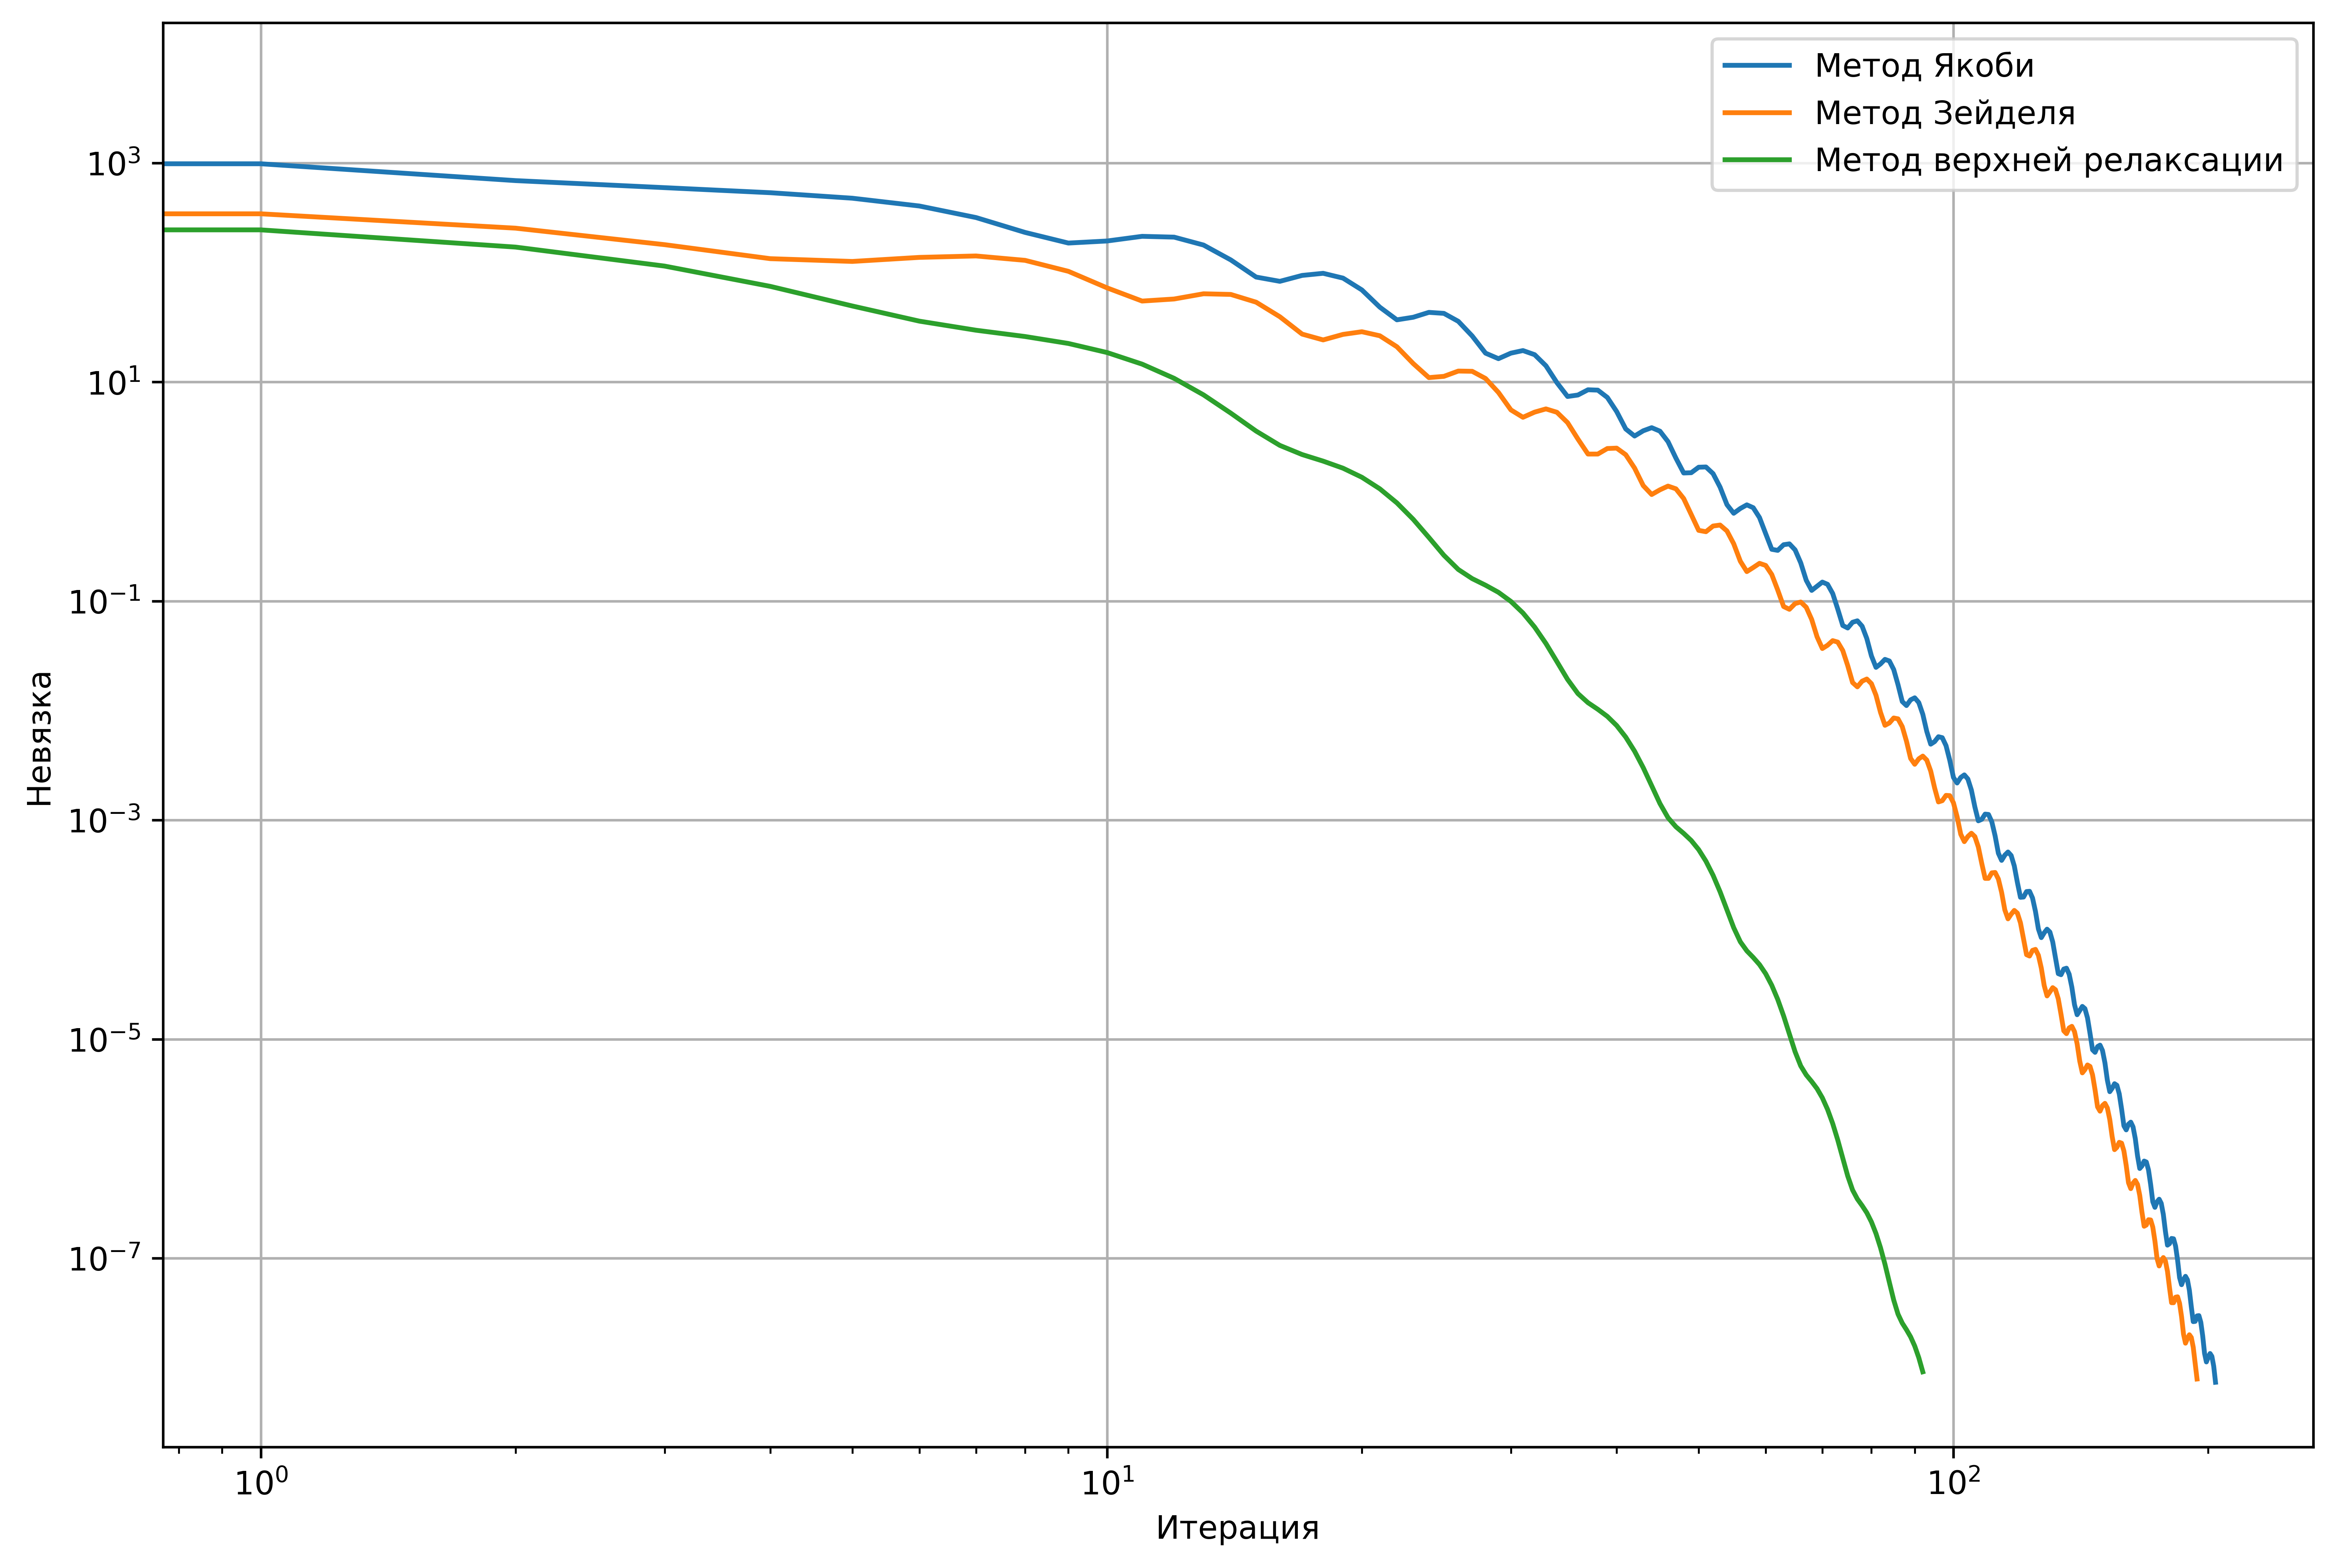

In [272]:
plt.figure(figsize = [12,8], dpi = 600)


plt.plot(np.arange(0, len(norms_Yakobi)), norms_Yakobi, label = "Метод Якоби")
plt.plot(np.arange(0, len(norms_Seidel)), norms_Seidel, label = "Метод Зейделя")
plt.plot(np.arange(0, len(norms_SOR)), norms_SOR, label = "Метод верхней релаксации")


plt.xlabel('Итерация')
plt.ylabel('Невязка')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid()
plt.show()